### Notebook Description

This notebook walks through the approach for implementing a method for generating parameter samples leveraging the properties of the nullspace matrix. The goal of this implementation is to establish a preliminary baseline method for initial deployment and subsequent improvement.

The approach demonstrated here follows a one-at-a-time process, where single parameter samples are chosen from the sample space and collected into a full set to be output from the function. In later versions, this process will be replaced with a Latin-Hypercube styled approach to achieve more robust representation of the parameter space.

### Import SBML Model

Before we begin the implementation, we must use previously discussed methods to create a SciPyModel of the proper form.

In [1]:
import os, sys
NotebookDirectory = os.path.split(os.getcwd())[0]
if NotebookDirectory not in sys.path:
    sys.path.append(NotebookDirectory)
from utils import SBML2SciPy

SciPyModel = SBML2SciPy.importSBMLFile(SBML2SciPy.createSciPyModel())
SciPyModel = SBML2SciPy.writeODEFunction( SciPyModel )
SciPyModel = SBML2SciPy.createNullSpaceFunction( SciPyModel )

### Specify Required Data

First the user must specify data on the sampling in the `SciPyModel` structure.

In [2]:
import numpy

# Specify the number of parameter sets to draw from the sample space
SciPyModel.SimulationData.Sensitivity.Global.NumSamples = 100

# Specify the minimum bounds for each parameter
SciPyModel.Parameters.MinimumValue = numpy.zeros(SciPyModel.Parameters.Quantity)

# Specify the maximum bounds for each parameter
SciPyModel.Parameters.MaximumValue = numpy.ones(SciPyModel.Parameters.Quantity)*2.

### Initialize Parameter Array

An empty numpy array is required to capture the parameter sets as they are generated one-at-a-time.

In [3]:
SciPyModel.SimulationData.Sensitivity.Global.ParameterSets = numpy.zeros([
    SciPyModel.SimulationData.Sensitivity.Global.NumSamples,
    SciPyModel.Parameters.Quantity
])

### Generate Parameter Sets

Finally we loop to generate

In [4]:
for i in range(SciPyModel.SimulationData.Sensitivity.Global.NumSamples):

    KSample = numpy.ones(sum(SciPyModel.Parameters.KineticFlag)) * numpy.inf

    counter = 0
    while counter < 10000:

        RanSample = numpy.random.rand(
            SciPyModel.Parameters.NullSpaceDimension +
            sum([not c for c in SciPyModel.Parameters.KineticFlag]))

        ESample = RanSample[SciPyModel.Parameters.NullSpaceDimension:]

        KSample = SciPyModel.ToolboxFunctions.NullSpaceFunction(
            list(ESample), list(SciPyModel.Species.Value)).dot(
                list(RanSample[:SciPyModel.Parameters.NullSpaceDimension]))

        if not ((KSample < SciPyModel.Parameters.
                 MinimumValue[SciPyModel.Parameters.KineticFlag]).any() or
                (KSample > SciPyModel.Parameters.
                 MaximumValue[SciPyModel.Parameters.KineticFlag]).any()):
            break

        counter += 1

    SciPyModel.SimulationData.Sensitivity.Global.ParameterSets[
        i, :] = numpy.concatenate([KSample.tolist()[0],
                                       ESample.tolist()])

### Validate Parameter Sets

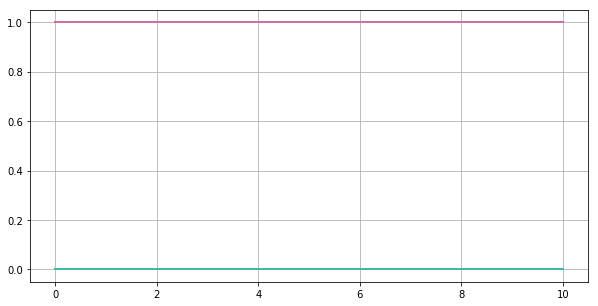

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.close()
plt.figure(figsize=(10, 5))

SciPyModel.SimulationData.TimeStart = 0
SciPyModel.SimulationData.TimeEnd = 10
SciPyModel.SimulationData.DataPoints = 100

for i in range(SciPyModel.SimulationData.Sensitivity.Global.NumSamples):

    SciPyModel.Parameters.Value = SciPyModel.SimulationData.Sensitivity.Global.ParameterSets[
        i, :]
    SciPyModel = SBML2SciPy.integrateODEFunction(SciPyModel)
    plt.plot(SciPyModel.SimulationData.Deterministic.TimeVector,
             SciPyModel.SimulationData.Deterministic.Data)
    
plt.grid()
plt.show()

### Plot Sample Space

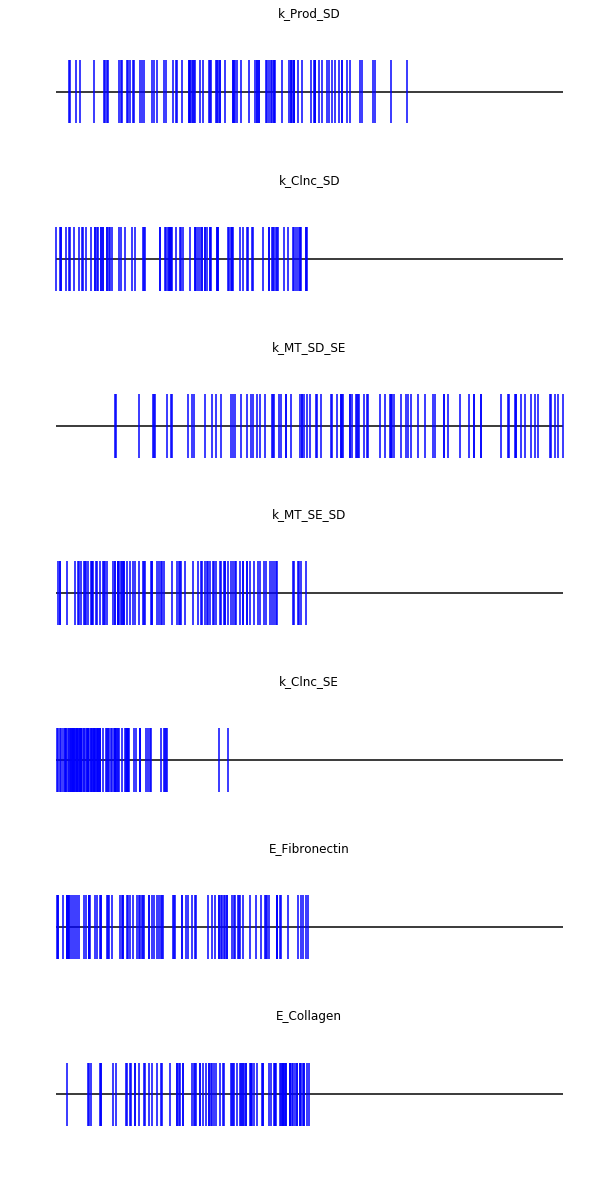

In [6]:
plt.figure(figsize=(10, 3 * SciPyModel.Parameters.Quantity))

for i in range(SciPyModel.Parameters.Quantity):

    plt.subplot(SciPyModel.Parameters.Quantity, 1, i + 1)

    plt.hlines(1, SciPyModel.Parameters.MinimumValue[i],
               SciPyModel.Parameters.MaximumValue[i])  # Draw a horizontal line

    plt.eventplot(
        SciPyModel.SimulationData.Sensitivity.Global.ParameterSets[:, i],
        orientation='horizontal',
        colors='b')
    plt.axis('off')
    plt.title(SciPyModel.Parameters.Names[i])

plt.show()